In [1]:
import datetime
import time

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import notebook_libs.utilities as util
import notebook_libs.prometheus as prom

## Experiment in Progress - Client Data

In [ ]:
while True:
    print(f"Updated {datetime.datetime.now()}")
    df = util.read_client_requests_in_progress()
    f, ax = plt.subplots(figsize=[8,4])
    util.plot_client_latency_distribution(df, "in-progress", ax)
    plt.show()
    result = prom.fetch_experiment_pod_data(int(14000/60.))
    util.plot_pod_metrics(result)
    plt.show()
    time.sleep(200)

## Experiment in Progress - Prometheus Data

In [ ]:
result = prom.fetch_experiment_pod_data(int(12000/60.))
util.plot_pod_metrics(result)

## Completed Experiments

In [2]:
print("\n".join([f"{i}: {x}" for i, x in enumerate(util.experiments)]))

0: 2023-02-15_2-replicas
1: 2023-02-16_4-replicas
2: 2023-02-16_6-replicas
3: 2023-02-17_3-replicas
4: 2023-02-17_5-replicas
5: 2023-02-19_2-replicas
6: 2023-02-20_5-replicas
7: 2023-02-15_3-replicas
8: 2023-02-16_5-replicas
9: 2023-02-16_6-replicas-2
10: 2023-02-17_4-replicas
11: 2023-02-18_3-replicas
12: 2023-02-19_4-replicas


In [3]:
current_experiment = util.experiments[6]

### Create 1-Minute buckets for client request data

In [ ]:
df, first_request_time, final_request_time = util.read_client_requests(current_experiment)
df_bucket = util.create_1_min_bucket_client_metrics(df)
df_bucket.plot(y=[
    "request_rate_per_min", 
    "avg_client_latency_ms",
    "std_client_latency_ms",
    "avg_response_function_latency_ms",
    "std_response_function_latency_ms"
]
,figsize=[8,12]
,title="Client Metrics (1Min Buckets)")

### Determine window boundaries

In [ ]:
df_client, first_request_time, final_request_time = util.read_client_requests(current_experiment)
first_request_time = int(first_request_time)
final_request_time = int(final_request_time + 120)
print(first_request_time, final_request_time)

In [ ]:
df_client.describe()

## Compare a Group of Experiments

In [ ]:
print(util.experiments)
util.compare_client_latency_distributions()

## Experiment Complete - Compare data window between Client and Prometheus

In [ ]:
df_pod = util.read_pod_df_list(current_experiment, first_request_time, final_request_time)
util.plot_pod_metrics(df_pod)

In [ ]:
df = util.combined_data_set(current_experiment)
df.head(10)

In [ ]:
df.plot.scatter(x="request_rate_per_min",y="cpu")
df.plot.scatter(x="request_rate_per_min",y="memory")

## Workload Response Model

In [4]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

2023-02-24 13:03:45.480038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dfs = [util.combined_data_set(ce) for ce in util.experiments]
df = pd.concat(dfs, axis=0)
# print(df.head(4))

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='replicas'>

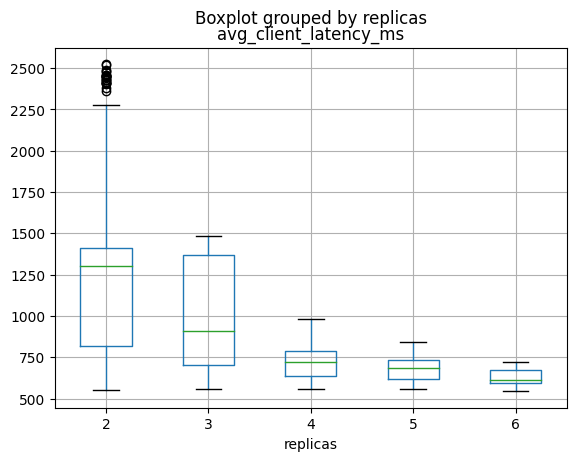

In [45]:
df.boxplot("avg_client_latency_ms", by="replicas")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_req_rate'>

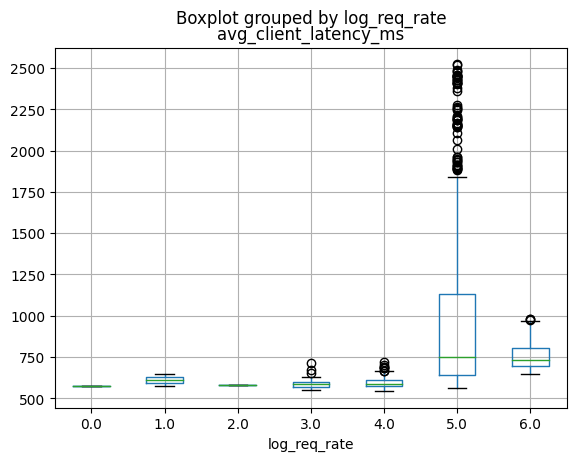

In [46]:
df["log_req_rate"] = df_train.request_rate_per_min.apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_req_rate")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_memory'>

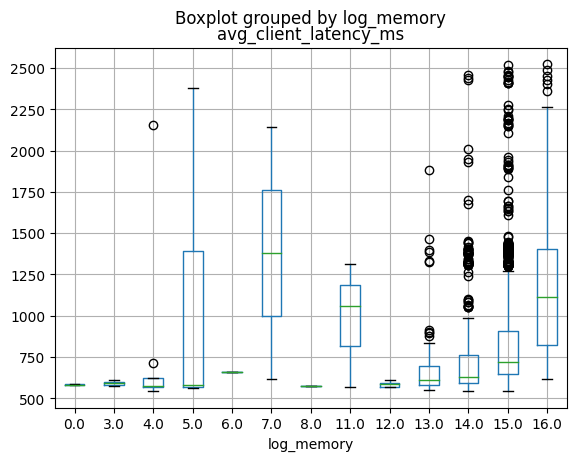

In [49]:
df["log_memory"] = df_train.memory.apply(lambda x: int(np.log(x+1)))
df.boxplot("avg_client_latency_ms", by="log_memory")

<Axes: title={'center': 'avg_client_latency_ms'}, xlabel='log_cpu'>

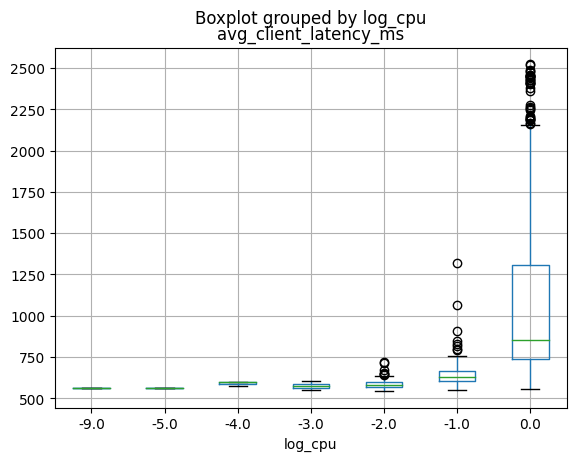

In [50]:
df["log_cpu"] = df_train.cpu.apply(lambda x: int(np.log(x)))
df.boxplot("avg_client_latency_ms", by="log_cpu")

In [6]:
df_train = df[[ "memory", "cpu", "request_rate_per_min", "avg_client_latency_ms", "replicas"]].copy()
df_train["avg_client_latency_ms"] = df_train["avg_client_latency_ms"].apply(lambda x: np.log(x))
df_train = df_train.dropna()

In [26]:
scaler.fit(df_train)
scaled = scaler.transform(df_train)
# scaled_df = pd.DataFrame(scaled, columns=df_train.columns)
X = scaled[:,[2,4]]
y = scaled[:,[0,1,3]]

In [27]:
model = Sequential()
model.add(Dense(10, input_shape=(2,), activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='relu'))
# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X, y, epochs=65, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/65
234/234 [==============================] - 1s 870us/step - loss: 0.0828 - accuracy: 0.4749
Epoch 2/65
234/234 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.6518
Epoch 3/65
234/234 [==============================] - 0s 928us/step - loss: 0.0534 - accuracy: 0.6518
Epoch 4/65
234/234 [==============================] - 0s 743us/step - loss: 0.0532 - accuracy: 0.6518
Epoch 5/65
234/234 [==============================] - 0s 775us/step - loss: 0.0530 - accuracy: 0.6518
Epoch 6/65
234/234 [==============================] - 0s 737us/step - loss: 0.0528 - accuracy: 0.6518
Epoch 7/65
234/234 [==============================] - 0s 807us/step - loss: 0.0525 - accuracy: 0.6518
Epoch 8/65
234/234 [==============================] - 0s 769us/step - loss: 0.0521 - accuracy: 0.6518
Epoch 9/65
234/234 [==============================] - 0s 738us/step - loss: 0.0518 - accuracy: 0.6518
Epoch 10/65
234/234 [==============================] - 0s 762us/step - loss: 0.0515 

In [28]:
print(X.shape, y.shape)
print(X[1300,:], y[0,:])

(2335, 2) (2335, 3)
[0.21138211 0.25      ] [0.29837744 0.15441668 0.03224196]


In [43]:
def scan_for_replicas(model, scaler, req_rate, last_n, latency_target = 600, delta_n = 3, n_min = 2, n_max = 6):
    lat_data = []
    ns = np.array(range(max(n_min, last_n-delta_n), min(last_n+delta_n, n_max)))
    for n in ns:
        X = scaler.transform(np.array([0, 0, req_rate, 0, n]).reshape(1, -1))[:,[2,4]]
        _y = model.predict(X)[0]
        pred_lat = scaler.inverse_transform(np.array([_y[0], _y[1], req_rate, _y[2], n]).reshape(1, -1))
        lat_data.append(pred_lat[0][3])
    i, = np.where(np.array(lat_data) < np.log(latency_target))
    #print("target ", np.log(latency_target))
    #print("latency", lat_data)
    #print("     ns", ns)
    #print(i, ns[i])
    #print(min(ns[i]))
    try:
        res = min(ns[i])
    except (ValueError) as e:
        res = n_max
    return res

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 20ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 18ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - ETA: 0s

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 14ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - ETA: 0s

/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  war

1/1 [==============================] - 0s 15ms/step


/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/s.hendrickson/Library/Caches/pypoetry/virtualenvs/loadflaskdeploy-mJ1-TA_o-py3.10/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


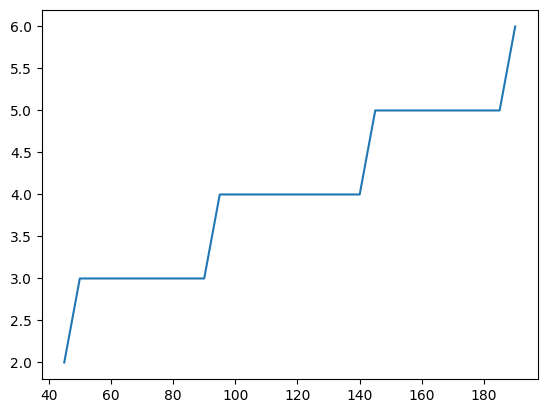

In [44]:
data=[]
for rr in range(45, 195, 5):
    data.append((rr, scan_for_replicas(model, scaler, rr, 4)))

data = np.array(data)
plt.plot(data.T[0], data.T[1])    

### To Do
* correlations between client and server metrics
* what parameters to scan with more tests?
* how long is 10K transactions?